In [1]:
%matplotlib notebook
#%matplotlib inline

In [2]:
from osgeo import gdal
import numpy as np
import matplotlib.pyplot as plt
from pygeotools.lib import iolib, warplib, geolib, timelib, malib

In [3]:
dem_1970_fn = '19700901_ned1_2003_adj_warp.tif'
dem_2008_fn = '20080901_rainierlidar_10m-adj.tif'
dem_2015_fn = '20150818_rainier_summer-tile-0.tif'
dem_fn_list = [dem_1970_fn, dem_2008_fn, dem_2015_fn]

In [4]:
ds_list = warplib.memwarp_multi_fn(dem_fn_list, extent='intersection', res='min', t_srs=dem_2015_fn)


Warping all inputs to the following:
Resolution: 8.0
Extent: [583464.253406, 5179709.0989, 608272.253406, 5202549.0989]
Projection: '+proj=utm +zone=10 +datum=WGS84 +units=m +no_defs'
Resampling alg: cubic

1 of 3: 19700901_ned1_2003_adj_warp.tif
nl: 2855 ns: 3101 res: 8.000
0...10...20...30...40...50...60...70...80...90...2 of 3: 20080901_rainierlidar_10m-adj.tif
nl: 2855 ns: 3101 res: 8.000
100 - done.
0...10...20...30...40...50...60...70...80...90...3 of 3: 20150818_rainier_summer-tile-0.tif


In [6]:
dem_1970, dem_2008, dem_2015 = [iolib.ds_getma(i) for i in ds_list]
dem_list = [dem_1970, dem_2008, dem_2015]

In [7]:
print(dem_2015.shape)
print(dem_2015.dtype)

dem_2015

(2855, 3101)
float32


masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [1420.24169921875, 1425.361083984375, 1426.648681640625, ..., --,
         --, --],
        [1412.8729248046875, 1419.9056396484375, 1423.5897216796875, ...,
         --, --, --],
        [1409.49169921875, 1414.83837890625, 1417.3895263671875, ..., --,
         --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True]],
  fill_value=0.0,
  dtype=float32)

In [8]:
summit_idx = np.unravel_index(dem_2008.argmax(), dem_2008.shape)
for dem in dem_list:
    #print(summit_idx)
    print('%0.1f m (%0.1f ft)' % (dem[summit_idx], (dem[summit_idx]*3.28084)))

4373.6 m (14349.2 ft)
4373.6 m (14349.2 ft)
4370.7 m (14339.5 ft)


In [9]:
#Function to generate a 3-panel plot for input arrays
def plot3panel(dem_list, clim=None, titles=None, cmap='inferno', label=None, overlay=None, fn=None):
    fig, axa = plt.subplots(1,3, sharex=True, sharey=True, figsize=(10,4))
    alpha = 1.0
    for n, ax in enumerate(axa):
        #Gray background
        ax.set_facecolor('0.5')
        #Force aspect ratio to match images
        ax.set(adjustable='box', aspect='equal')
        #Turn off axes labels/ticks
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if titles is not None:
            ax.set_title(titles[n])
        #Plot background shaded relief map
        if overlay is not None:
            alpha = 0.7
            axa[n].imshow(overlay[n], cmap='gray', clim=(1,255)) 
    #Plot each array 
    im_list = [axa[i].imshow(dem_list[i], clim=clim, cmap=cmap, alpha=alpha) for i in range(len(dem_list))]
    fig.tight_layout()
    fig.colorbar(im_list[0], ax=axa.ravel().tolist(), label=label, extend='both', shrink=0.5)
    if fn is not None:
        fig.savefig(fn, bbox_inches='tight', pad_inches=0, dpi=150)
    plt.show()


<IPython.core.display.Javascript object>


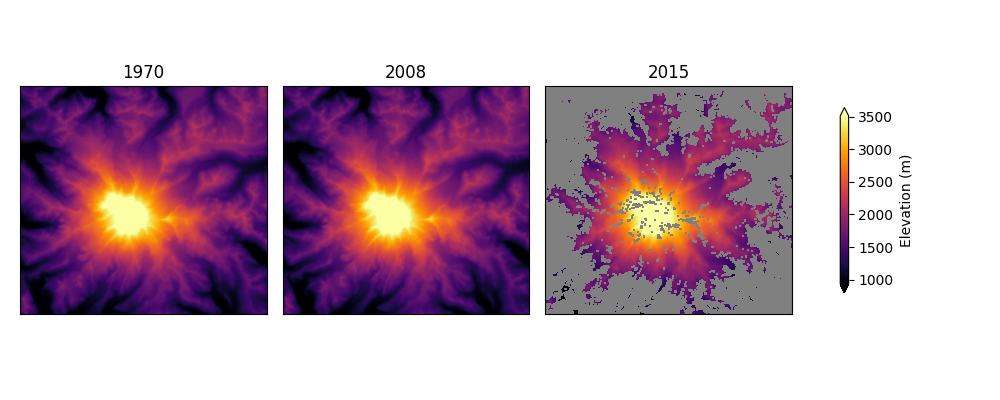

In [10]:
titles = ['1970', '2008', '2015']
clim = malib.calcperc(dem_list[0], (2,98))
plot3panel(dem_list, clim, titles, 'inferno', 'Elevation (m)')

<IPython.core.display.Javascript object>


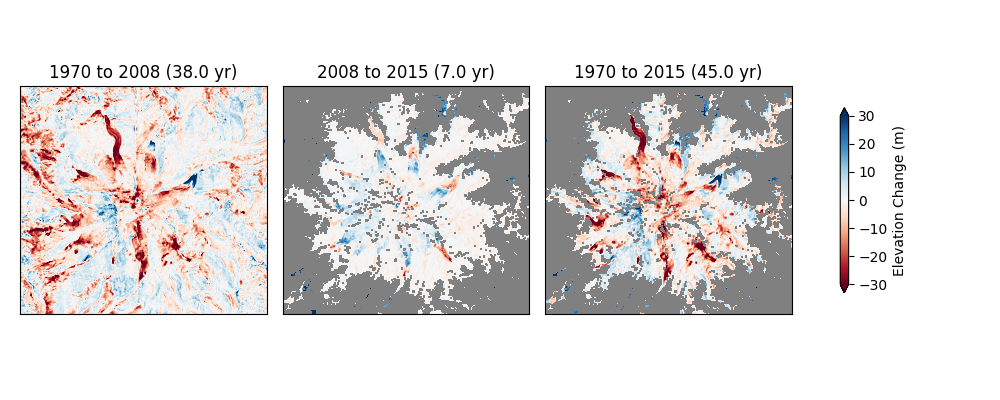

In [11]:
dh_list = [dem_2008 - dem_1970, dem_2015 - dem_2008, dem_2015 - dem_1970]

t_list = np.array([timelib.fn_getdatetime(fn) for fn in dem_fn_list])

dt_list = [timelib.timedelta2decyear(d) for d in np.diff(t_list)]

dt_list.append(dt_list[0]+dt_list[1])


titles = ['1970 to 2008 (%0.1f yr)' % dt_list[0], '2008 to 2015 (%0.1f yr)' % dt_list[1], '1970 to 2015 (%0.1f yr)' % dt_list[2]]
plot3panel(dh_list, (-30, 30), titles, 'RdBu', 'Elevation Change (m)')

<IPython.core.display.Javascript object>


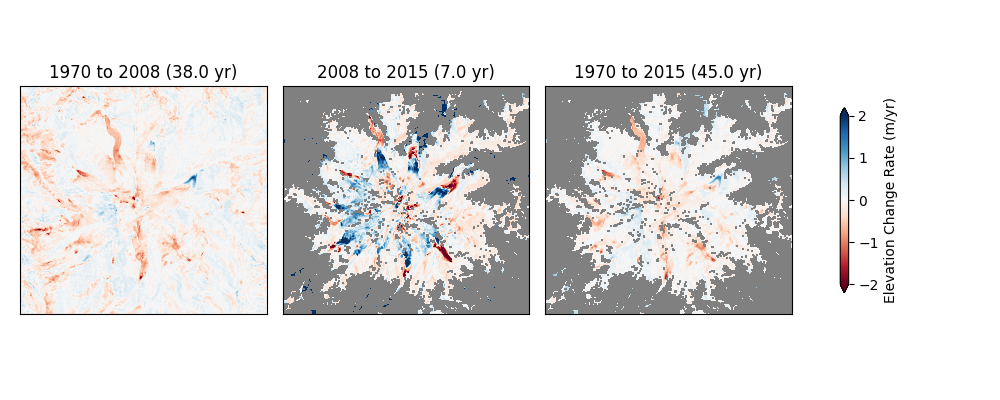

In [12]:
dhdt_list = np.ma.array(dh_list)/np.array(dt_list)[:,np.newaxis,np.newaxis]
plot3panel(dhdt_list, (-2, 2), titles, 'RdBu', 'Elevation Change Rate (m/yr)')